In [1]:
from shapely.geometry import Polygon 
import numpy as np
import copy
import matplotlib.pyplot as plt
import math

4
POLYGON ((-1 -2, -1 2, 2 1, 2 -1, -1 -2))


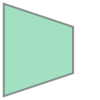

In [2]:
np.random.seed(5)
# 生成点集
# 案例一
# Z = np.random.randint(low=-10,high=11,size=(20,2))
# 案例二
Z = np.array([[2, 1], [2, -1], [-1, 2], [-1, -2]])
Z = [tuple(i) for i in Z]
k = set()
for i in Z:
    k.add(i)
Z = list(k)
print(len(Z))
polygon = Polygon(Z) 
co_Z = polygon.convex_hull # 调用shapely库计算出凸包
print(co_Z)
c=list(co_Z.exterior.coords)
co_Z

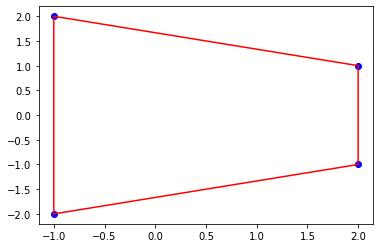

In [3]:
k = list(co_Z.exterior.coords)
x = [i[0] for i in Z]
y = [i[1] for i in Z]
x1 = [i[0] for i in c]
y1 = [i[1] for i in c]
plt.scatter(x, y, c='b')
plt.plot(x1, y1, c='r')
plt.savefig('figures/集合1.png', dpi=900)

In [4]:
def distance(x:tuple,y:tuple)->float:
    '''向量x,y之间的距离'''
    if len(x) == len(y):
        dist = 0
        for i in range(len(x)):
            dist+=(x[i] - y [i])**2
        return dist**0.5
    
def d_max(x:tuple,Z:list)->float:
    max = 0
    for i in Z:
        dist = distance(x,i)
        if dist >= max:
            max = dist
    return max

def f_E(x:tuple,Z:list,dmax:float)->list:
    '''获取到集合Z中与x距离为dmax的点'''
    Ex=[]
    for i in Z:
        if math.fabs(distance(x,i) - dmax) < 1e-3:
            Ex.append(i)
    return Ex

def set_equal(x:list,y:list)->bool:
    '''判断量点集是否相等'''
    for i,j in zip(x,y):
        if i!=j:
            return False
    else:
        return True

def get_convex_hull(x:list,paint = False)->list:
    '''获得集合的凸包'''
    if len(x) <= 2:
        return x
    polygon = Polygon(x) 
    co_Z = polygon.convex_hull # 调用shapely库计算出凸包
    if str(type(co_Z)) == "<class 'shapely.geometry.linestring.LineString'>":    
        return list(co_Z.coords)
    else:
        if paint:
            return list(co_Z.exterior.coords)
        else:
            return  list(co_Z.exterior.coords)[:-1]

def init_Z(key=3,level=10,vertical=5,num=900)->list:
    '''初始化点集Z'''
    seed = np.random.RandomState(key)
    seed2 = np.random.RandomState(key+1)
    Z1 = seed.rand(num,1)*level #生成点集
    Z2 = seed2.rand(num,1)*vertical
    Z = np.concatenate([Z1,Z2],axis = 1)
    Z = [tuple(i) for i in Z]
    k = set()
    for i in Z:
        k.add(i)
    Z = list(k)
    return Z

def is_in_convex_hull(x:tuple,hull:list)->bool:
    '''判断点是否在凸包内'''
    #将点加入凸包集合，对新的集合生成凸包
    #若新的凸包和原来的凸包相等，则点在凸包内，否则不在凸包内
    if len(hull) == 1:
        return x == hull[0]
    else:
        temp = copy.deepcopy(hull)
        temp.append(x)
        new_hull = get_convex_hull(temp)
        if new_hull == hull:
            return True
        else:
            return False
def get_point_in_hull(Z:list,hull:list)->list:
    '''获取点集Z中属于凸包hull的点'''
    points=[]
    for i in Z:
        if is_in_convex_hull(i,hull):
            points.append(i)
    return points
def get_nearest_point(set:list,x:tuple)->tuple:
    '''获取E(x)中与x距离最近的点y'''
    min = distance(x,set[0])
    nearest_point = set[0]
    for i in set:
        if distance(x,i) <= min:
            min = distance(x,i)
            nearest_point = i
    return nearest_point

def get_zi(Z:list,Ex:list)->list:
    temp = copy.deepcopy(Z)
    for i in Z:
        for j in Ex:
            if i == j:
                temp.remove(i)
                break
    return temp

def dot(x:tuple,y:tuple)->float:
    '''向量点积'''
    return x[0]*y[0] + x[1]*y[1]

def sub(x:tuple,y:tuple)->tuple:
    '''向量相减'''
    return (x[0]-y[0],x[1]-y[1])

def add(x:tuple,y:tuple)->tuple:
    return (x[0]+y[0],x[1]+y[1])

def point_dot(x:float,y:tuple)->tuple:
    return (x*y[0],x*y[1])

def get_alpha(zi:list,x:tuple,y:tuple,dmax:float):
    min = 999
    for i in zi:
        numerator = distance(i,x)**2 - dmax**2
        denominator = 2*(dot(sub(y,x),sub(i,y)))
        if denominator>= 0 or math.fabs(denominator - 0) < 1e-4:
            continue
        alpha = numerator/denominator
        if alpha < min :
            min = alpha
    return min

In [5]:
step=0
xcpth=[]
#step0
# Z = init_Z(3,num=10,level=10,vertical=8)
Z_hull = get_convex_hull(Z)
x = Z[1]
xcpth.append(x)
while(True):
    #step1
    dmax = d_max(x,Z)
    Ex = f_E(x,Z,dmax)
    print(Ex)
    for k in Ex:
        xcpth.append(k)
    if Ex == Z:
        xc = x
        print(1)
        break
    #step2
    co_Ex = get_convex_hull(Ex)
    co_Ex = get_point_in_hull(Z,co_Ex)
    y = get_nearest_point(co_Ex,x)
    if y == x:
        xc = x
        print(2)
        break
    #step3
    zi = get_zi(Z,Ex)
    alpha = get_alpha(zi,x,y,dmax)
    xcpth.append(sub(y,x))
    if alpha >= 1:
        xc = y
        print(3)
        break
    #step4
    x_alpha = add(x,point_dot(alpha,sub(y,x)))
    Z.append(x)
    step+=1
    flag = math.fabs(dot((1,1),sub(x_alpha,x)))
    if flag < 1e-2:
        xc = x_alpha
        print(4)
        break
    x = x_alpha
    xcpth.append(x)

[(2, 1)]
[(-1, 2), (2, 1)]
[(2, 1)]
[(-1, 2), (2, 1)]
[(-1, 2)]
[(-1, -2), (-1, 2), (-1, -2)]
[(-1, 2)]
[(-1, -2), (-1, 2), (-1, -2)]
[(-1, 2)]
4


(0.00717360114777611, 3.660266534311063e-16)


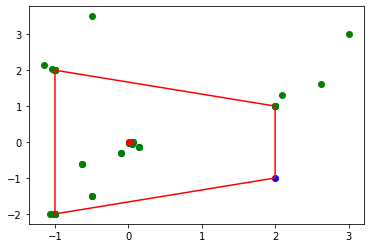

In [6]:
x = [i[0] for i in Z]
y = [i[1] for i in Z]
hull = get_convex_hull(Z,True)
x1 = [i[0] for i in hull]
y1 = [i[1] for i in hull]
print(xc)
plt.scatter(x, y, c='b')
plt.plot(x1, y1, c='r')
plt.scatter(xc[0],xc[1],c="r")
xcpth = np.array(xcpth)
plt.scatter(xcpth[:,0],xcpth[:,1],c="g")
plt.scatter(xc[0],xc[1],c="r")
plt.savefig('figures/center_1.png', dpi=900)
# plt.xlim(-2,10)
# plt.ylim(-2,10)